In [1]:
!pip install datasets[vision] keras tensorflow opencv-python-headless matplotlib scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for datasets[vision] from https://files.pythonhosted.org/packages/09/7e/fd4d6441a541dba61d0acb3c1fd5df53214c2e9033854e837a99dd9e0793/datasets-2.14.5-py3-none-any.whl.metadata
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metad

In [2]:
# import modules
import datasets
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from functools import partial
from sklearn.neighbors import NearestNeighbors
import pandas as pd

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import (load_img, img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, preprocess_input)

2023-10-06 12:17:43.690961: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 12:17:43.695092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 12:17:43.731816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 12:17:43.731834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 12:17:43.731862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
from functools import partial

wikiart = datasets.load_dataset("huggan/wikiart", split='train', streaming=True).take(50000)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

ds = datasets.Dataset.from_generator(partial(gen_from_iterable_dataset, wikiart), features=wikiart.features)

ds.save_to_disk("wikiart_50k")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/43 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
def extract_features(img, model):
    """
    Extract features from image data using pretrained model (e.g. VGG16)

    Arguments:
    - img_path: path to image to extract features on
    - model: model to use as a feature extractor

    Returns:
    - A list of image embeddings for the input image

    Source:
        This function is taken from the Session 10 Notebook for the Visual Analytics Course.
    """

    img = img.resize((224, 224))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img)
    # flatten into 1D
    flattened_features = features.flatten()
    # normalise features
    #normalized_features = flattened_features / norm(features)

    return flattened_features

In [4]:
# loading vgg16 model with avg. pooling
model = VGG16(weights='imagenet',
            include_top=False,
            pooling='avg',
            input_shape=(224, 224, 3))

2023-10-06 12:17:45.188946: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 4751360/58889256 [=>............................] - ETA: 7s 

58889256/58889256 [==============================] - 2s 0us/step


In [5]:
ds = datasets.load_from_disk("wikiart_50k")
ds_split = ds.train_test_split(test_size=0.2, seed=2830)

In [6]:
ds_Train = ds_split['train']
ds_Test = ds_split['test']

In [7]:
feature_list_train = []
feature_list_test = []

for i in range(len(ds_Train)):
    im = ds_Train[i]['image']
    feature = extract_features(im, model)
    feature_list_train.append(feature)

for i in range(len(ds_Test)):
    im = ds_Test[i]['image']
    feature = extract_features(im, model)
    feature_list_test.append(feature)

features_train = np.asarray(feature_list_train)
features_test = np.asarray(feature_list_test)

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 48ms/step


In [8]:

np.save('features_train.npy', features_train)
np.save('features_test.npy', features_test)

#features_train = np.load('features_train.npy')
#features_test = np.load('features_test.npy')

In [16]:
ds_Train.save_to_disk("wiki_train")
ds_Test.save_to_disk("wiki_test")

Saving the dataset (0/35 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

Saving the dataset (0/9 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
def pretrained_autoencoder(inp_shape, latent_shape):
    #n_layers = 4
    input_img = tf.keras.layers.Input(shape=(inp_shape,), name='input')

    enc1 = tf.keras.layers.Dense(300, activation = 'relu', name='encoder1')(input_img)
    #enc2 = tf.keras.layers.Dense(200, activation = 'relu', name='encoder2')(enc1)
    
    embedding = tf.keras.layers.Dense(latent_shape, activation = 'relu')(enc1)
    
    #dec1 = tf.keras.layers.Dense(200, activation = 'relu', name='decoder1')(embedding)
    dec2 = tf.keras.layers.Dense(300, activation = 'relu', name='decoder2')(embedding)

    decoded = tf.keras.layers.Dense(inp_shape, activation = 'relu', name='decoder3')(dec2)

    autoencoder, encoder = tf.keras.models.Model(inputs=input_img, outputs=decoded, name='AE'), tf.keras.models.Model(inputs=embedding, outputs=decoded, name='decoder')

    return autoencoder, encoder

In [11]:
autoencoder, encoder = pretrained_autoencoder(512, 150)
autoencoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512)]             0         
                                                                 
 encoder1 (Dense)            (None, 300)               153900    
                                                                 
 dense (Dense)               (None, 150)               45150     
                                                                 
 decoder2 (Dense)            (None, 300)               45300     
                                                                 
 decoder3 (Dense)            (None, 512)               154112    
                                                                 
Total params: 398462 (1.52 MB)
Trainable params: 398462 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(features_train, features_train, epochs=30)

Epoch 1/30
1250/1250 [==============================] - 8s 6ms/step - loss: 3.1416
Epoch 2/30
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0805
Epoch 3/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9515
Epoch 4/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9038
Epoch 5/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.8671
Epoch 6/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.8387
Epoch 7/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8245
Epoch 8/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8104
Epoch 9/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7969
Epoch 10/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7851
Epoch 11/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7744
Epoch 12/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7689
E

In [13]:
prediction = autoencoder.predict(features_test)

313/313 [==============================] - 1s 2ms/step


In [14]:
# calculate average reconstruction error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(features_test, prediction)
print(mse)

1.6473885


In [15]:
# calculate for each image
errors = []

for i in range(len(features_test)):
    mse = mean_squared_error(features_test[i], prediction[i])
    errors.append(mse)

### Find and show similar images based on K-Nearest Neighbors algorithm

In [17]:

# find K-nearest neighbors
def find_neighbors(feature_list, target_image):
    '''
    Calculate nearest neighbors to a target image using a feature list
    Saves a .csv file from a Pandas dataframe containing the 5 closest images

    Arguments:
    - feature_list: list of extracted features for each image
    - filenames: list of filenames for data directory
    - target_image: name of target image
    - out_folder: where to save the output csv

    Returns:
    - A Pandas series containing the names of the 5 nearest neighbors.
    '''

    # initialize K-nearest neighbors algorithm
    neighbors = NearestNeighbors(n_neighbors=10, 
                            algorithm='brute',
                            metric='cosine').fit(feature_list)

    # find the index of target image in filenames list
    

    # save the indices and distances of the neighbors to the target image
    distances, indices = neighbors.kneighbors([feature_list[target_image]])

    # initialize empty lists
    idxs = []
    dist = []
    
        # save the 5 closest images' indices and distances
    for i in range(1,6):
        idxs.append(indices[0][i])
        dist.append(distances[0][i])
    
    # save the filenames of the 5 closest images
    #names = [filenames[i] for i in idxs]

    # create dataframe
    data = pd.DataFrame({
                        "distance_score" : pd.Series(dist),
                        'index': pd.Series(idxs)})
    
    # save as csv
    #data.to_csv(os.path.join("out", out_folder, f"{target_image}.csv"))
    
    # return filenames as a pandas series to be used in the plotting function
    return data

In [18]:

def show_plot(names, target_image, dataset):
    '''
    Plot target image next to the five closest images

    Arguments:
    - path: path to folder where image data is stored
    - names: the filenames of the 5 closest images. Must be a pandas series
    - target_image: target input image
    - folder: specifies in what folder in output to save the plot to
    
    Returns:
    None
    '''
    
    # arrange plots
    f, axarr = plt.subplots(2, 3)
    
    # print target image
    axarr[0,0].imshow(dataset[target_image]['image'])
    axarr[0,0].title.set_text('Target Image')

    # plot 5 most similar next to it
    axarr[0,1].imshow(dataset[names[0]]['image'])
    axarr[0,2].imshow(dataset[names[1]]['image'])
    axarr[1,0].imshow(dataset[names[2]]['image'])
    axarr[1,1].imshow(dataset[names[3]]['image'])
    axarr[1,2].imshow(dataset[names[4]]['image'])
    
    # remove axes from plot
    for ax in f.axes:
        ax.axison = False

    plt.show()

In [19]:
def plot_neighbors(feature_list, target_image, dataset):

    # find closest images and save in a df
    data = find_neighbors(feature_list, target_image)

    # save the indices of the closest images
    indices = data['index'].tolist()

    # plot them
    show_plot(indices, target_image, dataset)

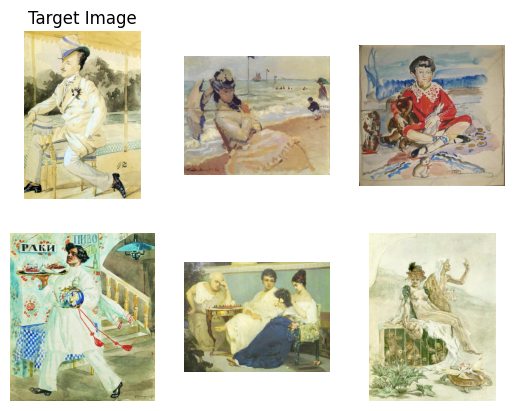

In [26]:
# original images
plot_neighbors(features_test, 989, ds_Test)

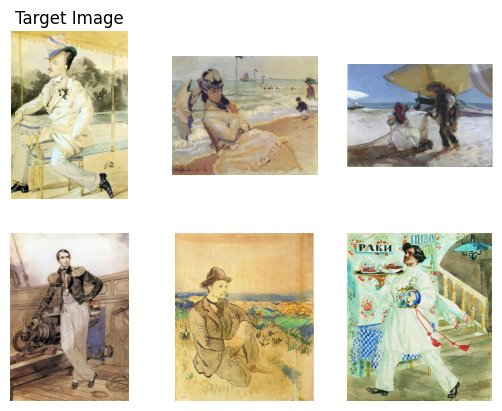

In [27]:
# reconstructions
plot_neighbors(prediction, 989, ds_Test)

### Create an autoencoder with a bigger encoded layer

In [30]:
def ae_larger_embedding(inp_shape, latent_shape):
    #n_layers = 4
    input_img = tf.keras.layers.Input(shape=(inp_shape,), name='input')

    enc1 = tf.keras.layers.Dense(800, activation = 'relu', name='encoder1')(input_img)
    #enc2 = tf.keras.layers.Dense(3000, activation = 'relu', name='encoder2')(enc1)
    
    embedding = tf.keras.layers.Dense(latent_shape, activation = 'relu', name='encoder3')(enc1)
    
    dec1 = tf.keras.layers.Dense(800, activation = 'relu', name='decoder1')(embedding)
    #dec2 = tf.keras.layers.Dense(3000, activation = 'relu', name='decoder2')(dec1)

    decoded = tf.keras.layers.Dense(inp_shape, activation = 'relu', name='decoder3')(dec1)

    autoencoder, encoder = tf.keras.models.Model(inputs=input_img, outputs=decoded, name='AE'), tf.keras.models.Model(inputs=embedding, outputs=decoded, name='decoder')

    return autoencoder, encoder

In [31]:
ae_big_embedding, encoder_big_embedding = ae_larger_embedding(512, 1200)

ae_big_embedding.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512)]             0         
                                                                 
 encoder1 (Dense)            (None, 800)               410400    
                                                                 
 encoder3 (Dense)            (None, 1200)              961200    
                                                                 
 decoder1 (Dense)            (None, 800)               960800    
                                                                 
 decoder3 (Dense)            (None, 512)               410112    
                                                                 
Total params: 2742512 (10.46 MB)
Trainable params: 2742512 (10.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# fit model
ae_big_embedding.compile(loss='mse', optimizer='adam')
ae_big_embedding.fit(features_train, features_train, epochs=30)

Epoch 1/30
1250/1250 [==============================] - 20s 15ms/step - loss: 2.5376
Epoch 2/30
1250/1250 [==============================] - 19s 15ms/step - loss: 1.5489
Epoch 3/30
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3024
Epoch 4/30
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1670
Epoch 5/30
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0825
Epoch 6/30
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0374
Epoch 7/30
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9917
Epoch 8/30
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9616
Epoch 9/30
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9392
Epoch 10/30
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9205
Epoch 11/30
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9022
Epoch 12/30
1250/1250 [==============================] - 19s 15

In [34]:
# Save both models

ae_big_embedding.save("ae_big_embedding.keras")
autoencoder.save("autoencoder_small.keras")


### Comparing the nearest neighbors for the original embeddings, the reconstructed embeddings from the small encoded vector (150) and the reconstructed embeddings from the large encoded vector (1200)

In [35]:
predictions_new = ae_big_embedding.predict(features_test)

313/313 [==============================] - 2s 5ms/step


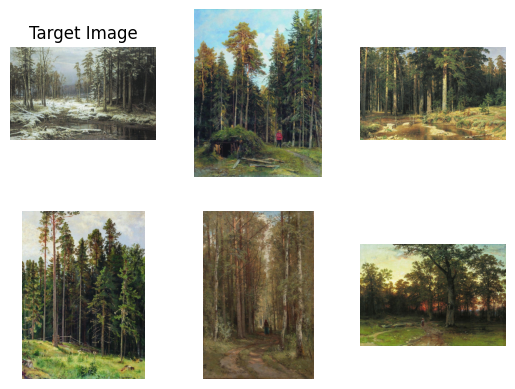

In [37]:
# original embeddings from VGG16
plot_neighbors(features_test, 898, ds_Test)

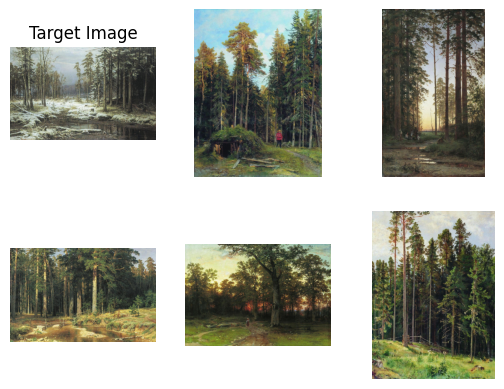

In [38]:
# reconstructions from the large encoded vector
plot_neighbors(predictions_new, 898, ds_Test)

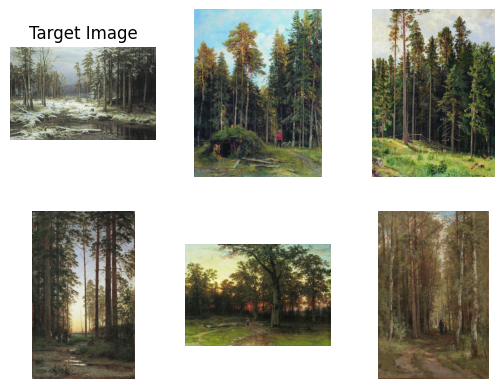

In [40]:
# reconstructions from the small encoded vector
plot_neighbors(prediction, 898, ds_Test)

In [41]:
errors_new = []

for i in range(len(features_test)):
    mse = mean_squared_error(features_test[i], predictions_new[i])
    errors_new.append(mse)

In [44]:
mse_new = mean_squared_error(features_test, predictions_new)
print(mse_new)

0.80888784


## Finding the images that are the hardest for the model to reconstruct

In [47]:
# hardest image for the small model
np.argmax(errors)

7189

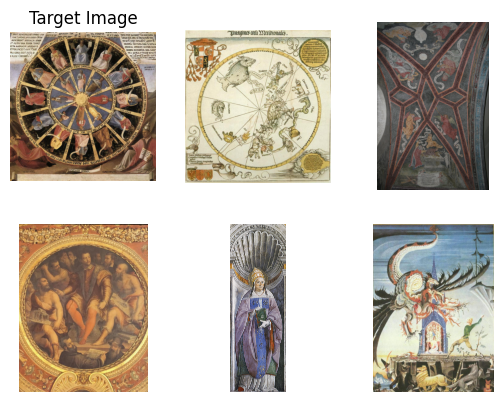

In [49]:
plot_neighbors(prediction, 7189, ds_Test)

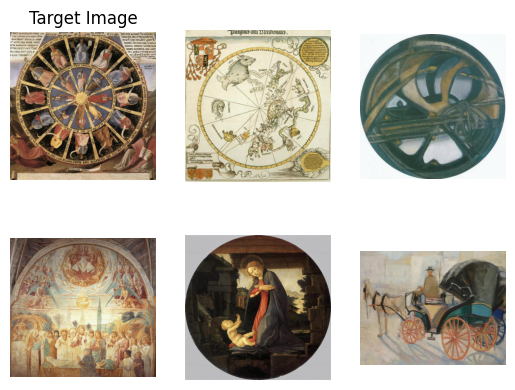

In [50]:
plot_neighbors(features_test, 7189, ds_Test)

In [42]:
# finding the image that is the hardest for the *big* model to reconstruct
np.argmax(errors_new)

1018

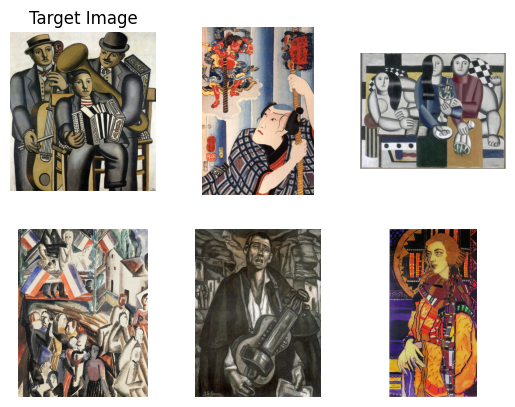

In [43]:
# plotting the image that was the hardest to reconstruct (i.e., 'the worst embedding')
plot_neighbors(predictions_new, 1018, ds_Test)

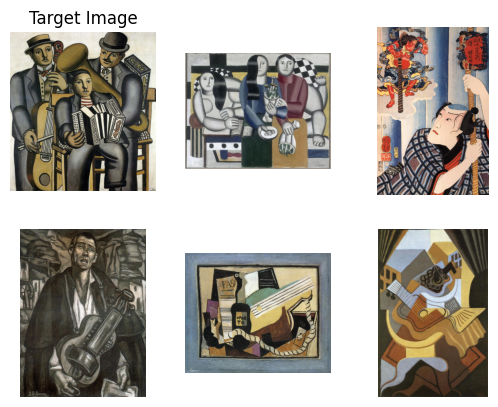

In [45]:
plot_neighbors(features_test, 1018, ds_Test)

#### Finding the image that is the easiest to reconstruct

In [51]:
np.argmin(errors)

8074

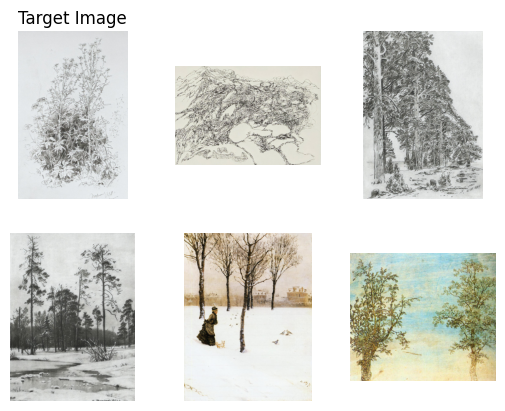

In [52]:
plot_neighbors(prediction, 8074, ds_Test)

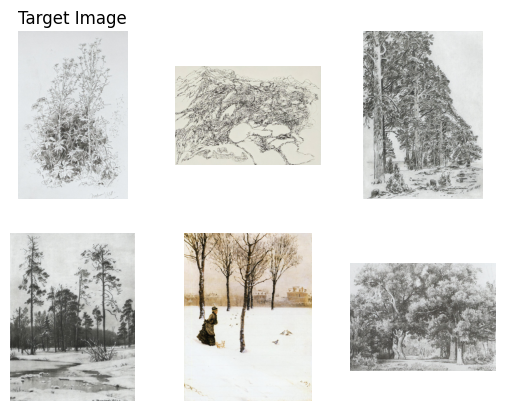

In [53]:
plot_neighbors(features_test, 8074, ds_Test)

In [54]:
np.argmin(errors_new)

7670

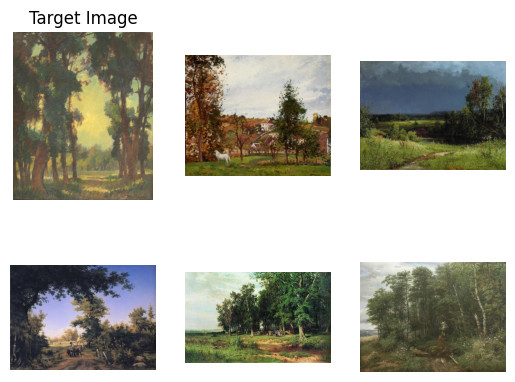

In [56]:
plot_neighbors(predictions_new, 7670, ds_Test)


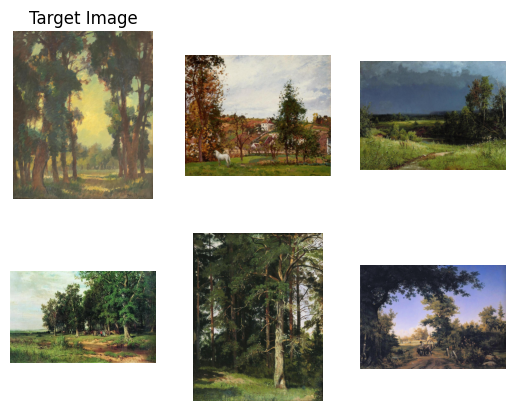

In [57]:
plot_neighbors(features_test, 7670, ds_Test)